## 03 Feature Extraction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import time

#### Check GPU availability

In [2]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) 
print("Configured device: ", device)

Configured device:  cuda:3


### 1. Loading Data

In [3]:
par = "par20"
file = "20-Name_2_2021-04-09-13.54.06" 
task = "_imagery"
model_name = "cnn"
drift = "drift"
# path = '../data/np/{par}/{file}{task}.npy'.format(par=par,file=file, task=task)

X = np.load('../data/np/round2/{par}/{drift}/{file}{task}_X.npy'.format(par=par,drift = drift,file=file, task=task), allow_pickle=True)
y = np.load('../data/np/round2/{par}/{drift}/{file}{task}_y.npy'.format(par=par,drift = drift,file=file, task=task), allow_pickle=True)

#### 1.1 Check shape

In [4]:
# [# stim, # electrod, # datapoint]
print(X.shape)
print(y.shape)

(150, 16, 49)
(150,)


#### 1.2 Plot

In [5]:
# ### Plot to see wheter eegs have drift or not
# print(X[100][0].shape)
# fig, ax = plt.subplots(16,1,figsize=(20,50),sharex=True)

# for i in range(data.shape[1]):
#     ax[i].plot(X[100][i])

### 2. Split data
- test_size: 0.1
- 10% of data is reserved for the real test --> X_test, y_test
- 90% will be again divided into (train,test,val) --> X_model, y_model

#### 2.1 Reserve some data for REAL TEST

In [6]:
from sklearn.model_selection import train_test_split

X_model, X_test, y_model, y_test = train_test_split( X, y, test_size=0.1, random_state=42)

In [7]:
print("Shape of X_model: ", X_model.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of y_model: ",y_model.shape)
print("Shape of y_test: ",y_test.shape)

Shape of X_model:  (135, 16, 49)
Shape of X_test:  (15, 16, 49)
Shape of y_model:  (135,)
Shape of y_test:  (15,)


#### 2.2 Chunking

- 10 can be thought of as totally new eeg records and will be used as the real evaluation of our model.
- For X : Chunking eeg to lengh of 10 data point in each stimuli's eeg
- For y(lebels) : Filled the lebels in y because we chunk X ( 1 stimuli into 6 chunk). We have 500 labels before but now we need 500 x 6 = 3000 labels

In [8]:
import sys
np.set_printoptions(threshold=sys.maxsize)

def chunk_data(data, size):
    data_keep = data.shape[2] - (data.shape[2]%size)
    #print(f'{data.shape}')
    data = data[:,:,:data_keep]
    #print(f'{data.shape}')
    #print(data[0,0,:20])
    data = data.reshape(-1,data.shape[1],data.shape[2]//size,size)
    #print(f'{data.shape}')
    #print(data[0,0,:2,:])
    data = np.transpose(data, (0, 2, 1, 3)  )
    #print(f'{data.shape}')
    #print(data[0,:2,0,:])
    return data

def filled_y(y, chunk_num):
    yy = np.array([[i] *chunk_num for i in  y ]).ravel()
    return yy

In [9]:
chunk_size = 10

print('=================== X ==================')
print(f'Oringinal X shape {X_model.shape}')
X = chunk_data(X_model, chunk_size)
print(f'Chunked X : {X.shape}') # (#stim, #chunks, #electrodes, #datapoint per chunk)
chunk_per_stim = X.shape[1]
X = X.reshape(-1,16,chunk_size)
print(f'Reshape X to : {X.shape}')
print('=================== y ==================')
print(f'Shape of y : {y_model.shape}')

# y_new = np.zeros(2430) #100 labels, 62 chunks per label
# print(y_new.shape)
# size = 25
# for i,marker in enumerate(y_model):
# #     print(marker)
#     y_new[i*size:(i+1)*size] = y_model[i]
# y = y_new
# print(y)
# print(y_new)
y_filled = filled_y(y_model, chunk_per_stim)
y = y_filled
# print(y_filled)
print(f'Shape of new y : {y.shape}')

=================== X ==================
Oringinal X shape (135, 16, 49)
Chunked X : (135, 4, 16, 10)
Reshape X to : (540, 16, 10)
=================== y ==================
Shape of y : (135,)
Shape of new y : (540,)


### 3. Define Model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import fnmatch

In [11]:
class EEGEncoder(nn.Module):
    '''
    Expected Input Shape: (batch, channels, height , width)
    '''
    def __init__(self):
        super().__init__()
        
        self.activation = nn.Tanh()
        
        self.conv1 = nn.Sequential(    nn.Conv1d(16, 32, kernel_size=(1,3),   padding=(0,0), stride=(1,1))  ,  self.activation )
        self.conv2 = nn.Sequential(    nn.Conv1d(32, 64, kernel_size=(1,3) ,  padding=(0,0), stride=(1,1))  ,  self.activation )
        # nn.Linear(XY,256) need to be changed!
        self.fc1   = nn.Sequential(    nn.Linear(384,256),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(256)   )
        self.fc2   = nn.Sequential(    nn.Linear(256,128),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(128) )
        self.fc3   = nn.Sequential(    nn.Linear(128,64),  self.activation  ,nn.Dropout(0.1)   ,nn.BatchNorm1d(64) )
        self.fc4   = nn.Sequential(    nn.Linear(64,32),  self.activation   ,nn.Dropout(0.1)   ,nn.BatchNorm1d(32) )
        self.fc5   = nn.Sequential(    nn.Linear(32,3)   )

        
        
    
        self.is_debug= False
        
    def encode(self, X):
        
        
        if self.is_debug  : print('--------Convolute--------'); print(X.shape) 
            
        X = self.conv1(X)
        if self.is_debug  : print(X.shape) 
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) 
            
        X = X.flatten(start_dim = 1)

        # print(X.shape) 
 
        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) 
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc5(X)
        if self.is_debug  : print(X.shape) 

            
        return X
        
    def forward(self,X):
        X = self.encode(X)
        return X
    
    def get_latent( self, X):
        if self.is_debug  : print('--------Convolute--------'); print(X.shape) 
            
        X = self.conv1(X)
        if self.is_debug  : print(X.shape) 
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) 
            
        X = X.flatten(start_dim = 1)
        if self.is_debug  : print('--------Flatten--------') ; print(X.shape) 
 
        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) 
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) 
        
        return X
    
    def classifier(self, latent):
        return self.fc5(latent)

### 4. Define Training function

Define the training process

We set `model.train()` so dropout is applied.

In [12]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    predicted_list = []
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch  = batch.to(device)
        labels = labels.to(device)
       
        
        #Forward pass
        outputs = model(batch.float())
        outputs = outputs.to(device)
        
        loss = criterion(outputs, labels.long()).to(device)

        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
        _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()  #.item() give the raw number
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        predicted_list.append(predicted)
        
    return epoch_loss / len(iterator), epoch_acc, predicted_list


def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    predicted_list = []
    labels_list    = []
        
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)
            
            #print(labels)
            

            predictions = model(batch.float())
            loss = criterion(predictions, labels.long())
            
            
            _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            #print(predicted)
#             clear_output(wait=True)
#             print('================== Predicted y ====================')
#             print(predicted) 
#             print('==================    True y   ====================')
#             print(labels)  
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
            
            labels_list.append(labels)
            predicted_list.append(predicted)
           

    return epoch_loss / len(iterator), epoch_acc / len(iterator) ,predicted_list, labels_list


# define a time function useful for calculating time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs



def do_plot(train_losses, valid_losses):
    plt.figure(figsize=(25,5))
#     clear_output(wait=True)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.title('Train and Val loss')
    plt.legend()
    plt.show()

### 5. Actual Training for Feature Extraction 


#### 5.1 Define model parameters
- Count model parameters
- optimizer
- loss function
- GPU

In [13]:
#Create the model from class
model_EEGEncoder = EEGEncoder()
model_EEGEncoder = model_EEGEncoder.float() #define precision as float to reduce running time
models = [model_EEGEncoder]


#Count the parameters for writing papers
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for model in models:
    print(f'The model {type(model).__name__} has {count_parameters(model):,} trainable parameters')# Train the model


The model EEGEncoder has 150,627 trainable parameters


#### 5.2 Prepare X and y in correct shape

- For X, pytorch (if set batch_first) LSTM requires to be (batch, seq_len, features).  Thus, for us, it should be (100, 75, 16).
- For y, nothing is special
- So let's convert our numpy to pytorch, and then reshape using view

In [14]:
torch_X = torch.from_numpy(X)
torch_y = torch.from_numpy(y)

print("Shape of torch_X: ",torch_X.shape)
print("Shape of torch_y: ",torch_y.shape)

Shape of torch_X:  torch.Size([540, 16, 10])
Shape of torch_y:  torch.Size([540])


In [15]:
print("Original X: ", torch_X.size())

Original X:  torch.Size([540, 16, 10])


CNN requires the input shape as (batch, channel, height, width)

In [16]:
torch_X_reshaped = torch_X.reshape(torch_X.shape[0],torch_X.shape[1],1,torch_X.shape[2])
print("Converted X to ", torch_X_reshaped.size())

Converted X to  torch.Size([540, 16, 1, 10])


#### 5.3 Split test train set, and load them into a DataLoader

In [17]:
from torch.utils.data import TensorDataset

# Define dataset
ds = TensorDataset(torch_X_reshaped, torch_y)

#Train test split
train_size = int(torch_X_reshaped.size()[0] * 0.7)
valid_size = int(torch_X_reshaped.size()[0] * 0.2)
test_size  = torch_X_reshaped.size()[0] - train_size - valid_size

train_set, valid_set, test_set = torch.utils.data.random_split(ds, [train_size, valid_size, test_size])



BATCH_SIZE = 128 #keeping it binary so it fits GPU
#Train set loader
train_iterator = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Validation set loader
valid_iterator = torch.utils.data.DataLoader(dataset=valid_set, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)

#Test set loader
test_iterator = torch.utils.data.DataLoader(dataset=test_set, 
                                          batch_size=test_size, 
                                          shuffle=True)


#### 5.4 Train the model

In [18]:
import torch.optim as optim

best_valid_loss = float('inf')
train_losses    = []
valid_losses    = []

learning_rate = 0.0001
N_EPOCHS      = 1000          ## best is 10k
criterion     = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate)


for model in models:
    model = model.to(device)
criterion = criterion.to(device)


Epoch: 1000/1000  |	Train Loss: 0.04205  | Train Acc: 98.94%  |	 Val. Loss: 1.01871  | Val. Acc: 71.30%


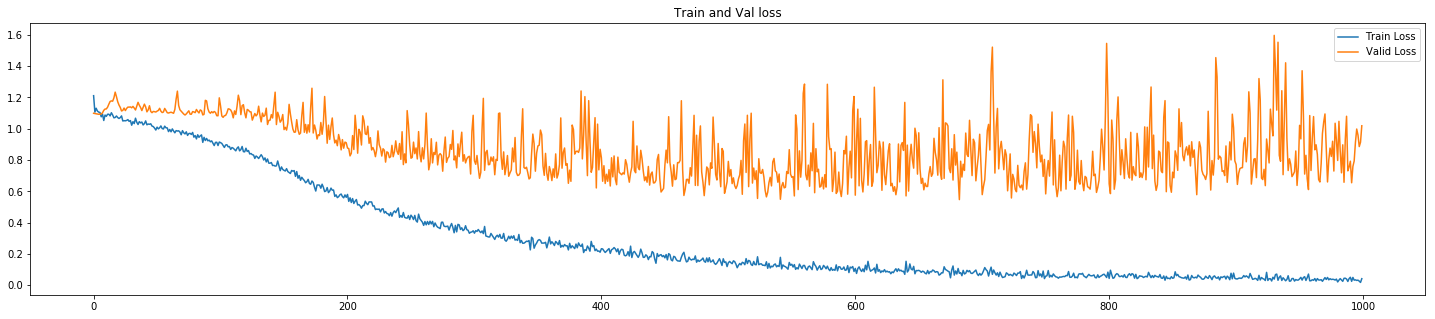

In [19]:
model.is_debug = False
iteration = 0

for i, model in enumerate(models):
    print(f"Training {type(model).__name__}")
    
    start_time = time.time()

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss, train_acc, train_predicted    = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc, valid_predicted, _ = evaluate(model, valid_iterator, criterion)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        iteration     += 1
        
        if (epoch+1) % 50 == 0:
            clear_output(wait=True)
            print(f'Epoch: {epoch+1:02}/{N_EPOCHS}  |',end='')
            print(f'\tTrain Loss: {train_loss:.5f}  | Train Acc: {train_acc:.2f}%  |', end='')
            print(f'\t Val. Loss: {valid_loss:.5f}  | Val. Acc: {valid_acc:.2f}%')
            do_plot(train_losses, valid_losses)
          

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print("Model:{} saved.".format(type(model).__name__))
            torch.save(model.state_dict(), "../model/feature_extraction/round2/{par}/{model_name}/{drift}/EEG_ENCODER{task}.pt.tar".format(par=par, model_name=model_name,drift=drift,task=task))
            best_model_index = i

### 7. Evaluation (Test model)
using test set

In [20]:
def squeeze_to_list(_tmp):
    from functools import reduce
    import operator

    xx     = [ i.cpu().detach().numpy().ravel().tolist() for i in _tmp]
    xx     = reduce(operator.concat, xx)
    return xx



models[best_model_index].load_state_dict(torch.load('../model/feature_extraction/round2/{par}/{model_name}/{drift}/EEG_ENCODER{task}.pt.tar'.format(par=par,model_name=model_name,drift=drift,task=task)))



# test_loss = evaluate(models[best_model_index], test_iterator, criterion)
# print(f'Test Loss: {test_loss}') # | Test Acc: {test_acc:.2f}%')

test_loss, test_acc , predicted, actual_labels = evaluate(models[best_model_index], test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
print("---------------")
print(" (Actual y , Predicted y)")

y_test_     = squeeze_to_list(actual_labels)
y_hat_test_ = squeeze_to_list(predicted)

out = zip(y_test_, y_hat_test_)

print(list(out))



Test Loss: 0.645 | Test Acc: 79.63%
---------------
 (Actual y , Predicted y)
[(2, 2), (1, 1), (2, 0), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (2, 2), (2, 2), (2, 2), (1, 1), (0, 2), (1, 1), (2, 2), (1, 0), (0, 0), (2, 2), (0, 1), (0, 2), (2, 2), (1, 1), (1, 1), (2, 2), (2, 2), (1, 0), (1, 0), (1, 0), (2, 2), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (1, 1), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2), (0, 0), (2, 2), (2, 2), (2, 2), (1, 0), (0, 0), (0, 0), (2, 2), (1, 0), (0, 0), (0, 0), (0, 0)]


### 8. For REAL TEST

In [21]:
# print(x_test)
X_test = chunk_data(X_test, chunk_size)
chunk_per_stim = X_test.shape[1]
X_test = X_test.reshape(-1,16,chunk_size)
y_filled_test = filled_y(y_test, chunk_per_stim)
print("Chucked X_test: ",X_test.shape )
print("y_filled_test: ",y_filled_test.shape )

Chucked X_test:  (60, 16, 10)
y_filled_test:  (60,)


In [22]:
#save for real test
np.save("../data/splits/{par}/X_test{task}".format(par=par,task=task),X_test)
np.save("../data/splits/{par}/y_test{task}".format(par=par,task=task),y_filled_test)

In [23]:
torch_X_test = torch.from_numpy(X_test)
torch_y_test = torch.from_numpy(y_filled_test)

print("Shape of torch_X: ",torch_X_test.shape)
print("Shape of torch_y: ",torch_y_test.shape)

Shape of torch_X:  torch.Size([60, 16, 10])
Shape of torch_y:  torch.Size([60])


In [24]:
torch_X_test_reshaped = torch_X_test.reshape(torch_X_test.shape[0],torch_X_test.shape[1],1,torch_X_test.shape[2])
print("Converted X to ", torch_X_test_reshaped.size())

Converted X to  torch.Size([60, 16, 1, 10])


In [25]:
ds = TensorDataset(torch_X_test_reshaped, torch_y_test)
#Test set loader
real_test_iterator = torch.utils.data.DataLoader(dataset=ds, 
                                          batch_size=test_size, 
                                          shuffle=True)

In [26]:
models[best_model_index].load_state_dict(torch.load('../model/feature_extraction/round2/{par}/{model_name}/{drift}/EEG_ENCODER{task}.pt.tar'.format(par=par,model_name=model_name,drift=drift,task=task)))



# test_loss = evaluate(models[best_model_index], test_iterator, criterion)
# print(f'Test Loss: {test_loss}') # | Test Acc: {test_acc:.2f}%')

test_loss, real_test_acc , predicted, actual_labels = evaluate(models[best_model_index], real_test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {real_test_acc:.2f}%')
print("---------------")
print(" (Actual y , Predicted y)")

y_test     = squeeze_to_list(actual_labels)
y_hat_test = squeeze_to_list(predicted)

out = zip(y_test, y_hat_test)

print(list(out))


Test Loss: 2.957 | Test Acc: 46.48%
---------------
 (Actual y , Predicted y)
[(0, 0), (0, 1), (0, 2), (0, 0), (0, 0), (1, 0), (0, 0), (1, 0), (2, 0), (0, 0), (0, 0), (2, 2), (0, 0), (2, 2), (1, 0), (0, 0), (0, 2), (1, 0), (1, 1), (1, 0), (0, 2), (1, 1), (0, 1), (1, 0), (1, 0), (2, 2), (0, 0), (1, 0), (2, 2), (0, 2), (1, 1), (0, 1), (0, 1), (1, 1), (0, 2), (2, 2), (0, 0), (1, 1), (2, 2), (0, 0), (1, 2), (0, 0), (1, 2), (1, 0), (1, 0), (1, 0), (1, 1), (1, 2), (0, 1), (0, 1), (1, 0), (1, 0), (0, 2), (0, 0), (0, 2), (0, 0), (1, 1), (2, 2), (0, 2), (1, 0)]


### 8. Save features extracted

In [27]:

# encoder_best_model = models[best_model_index].load_state_dict(torch.load(f'save/{type(model).__name__}{i}.pth.tar'))
# torch.save(encoder_best_model, 'save/7.1_encoder_best_model.pth.tar')


### save Encoder network
# torch.save(model_EEGEncoder, 'save/model_EEGEncoder_network_5s.pt.tar')
# torch.save(test_iterator,'save/eeg_X_test_5s.pt.tar')


# save extracted features
eeg_encode = model_EEGEncoder.get_latent(torch_X_reshaped.to(device).float())
eeg_extracted_features = eeg_encode.detach().cpu().numpy()
np.save('../data/extracted_features/round2/{par}/{file}{task}_X'.format(par=par,file=file, task=task), eeg_extracted_features )
np.save('../data/extracted_features/round2/{par}/{file}{task}_y'.format(par=par,file=file, task=task),y )

### 9. Results

In [28]:
print("Train Acc: ",train_acc)
print("Valid Acc: ",valid_acc)
print("Test Acc: ",test_acc)
print("Real test Acc: ",real_test_acc)

Train Acc:  98.94179894179894
Valid Acc:  71.29629629629629
Test Acc:  79.62962962962963
Real test Acc:  46.48148148148148


In [29]:
from sklearn.metrics import classification_report
target_names = ['R', 'G', 'B']
print('='*27,'TEST','='*27)
print(classification_report(y_test_, y_hat_test_, target_names=target_names, digits=4))
print('='*25,'REAL TEST','='*25)
print(classification_report(y_test, y_hat_test, target_names=target_names, digits=4))

=========================== TEST ===========================
             precision    recall  f1-score   support

          R     0.6500    0.7647    0.7027        17
          G     0.8333    0.6250    0.7143        16
          B     0.9091    0.9524    0.9302        21

avg / total     0.8051    0.7963    0.7946        54

========================= REAL TEST =========================
             precision    recall  f1-score   support

          R     0.4828    0.5000    0.4912        28
          G     0.5385    0.2917    0.3784        24
          B     0.3889    0.8750    0.5385         8

avg / total     0.4925    0.4667    0.4524        60

